In [1]:
import pandas as pd

# Load the dataset
file_path = 'EastWestAirlines.xlsx'
data = pd.read_excel(file_path, sheet_name='data')

# Display the first few rows of the dataset
data.head()


,ID#,Balance,Qual_miles,cc1_miles,cc2_miles,cc3_miles,Bonus_miles,Bonus_trans,Flight_miles_12mo,Flight_trans_12,Days_since_enroll,Award?
0,1,28143,0,1,1,1,174,1,0,0,7000,0
1,2,19244,0,1,1,1,215,2,0,0,6968,0
2,3,41354,0,1,1,1,4123,4,0,0,7034,0
3,4,14776,0,1,1,1,500,1,0,0,6952,0
4,5,97752,0,4,1,1,43300,26,2077,4,6935,1


In [3]:
# Check for missing values
missing_values = data.isnull().sum()

# Display columns with missing values
missing_values[missing_values > 0]

data.isna().sum()

ID#                  0
Balance              0
Qual_miles           0
cc1_miles            0
cc2_miles            0
cc3_miles            0
Bonus_miles          0
Bonus_trans          0
Flight_miles_12mo    0
Flight_trans_12      0
Days_since_enroll    0
Award?               0
dtype: int64

In [4]:
# Assuming we fill missing values with the mean
data.fillna(data.mean(), inplace=True)


In [6]:
import pandas as pd
import numpy as np
from scipy.stats import zscore

# Load the dataset
file_path = 'EastWestAirlines.xlsx'
data = pd.read_excel(file_path, sheet_name='data')

# Remove the ID column for clustering
data = data.drop(columns=['ID#'])

# Calculate z-scores
z_scores = zscore(data.select_dtypes(include=[np.number]))
abs_z_scores = np.abs(z_scores)

# Set a threshold for identifying outliers
threshold = 3

# Filter out outliers
data_no_outliers = data[(abs_z_scores < threshold).all(axis=1)]

print(f'Original data shape: {data.shape}')
print(f'Data shape after removing outliers: {data_no_outliers.shape}')


Original data shape: (3999, 11)
Data shape after removing outliers: (3630, 11)


In [7]:
from sklearn.preprocessing import StandardScaler

# Scale the features
scaler = StandardScaler()
scaled_data = scaler.fit_transform(data_no_outliers)

# Convert back to DataFrame for easier handling
scaled_data_df = pd.DataFrame(scaled_data, columns=data_no_outliers.columns)


C:\Users\Reshma\anaconda3\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


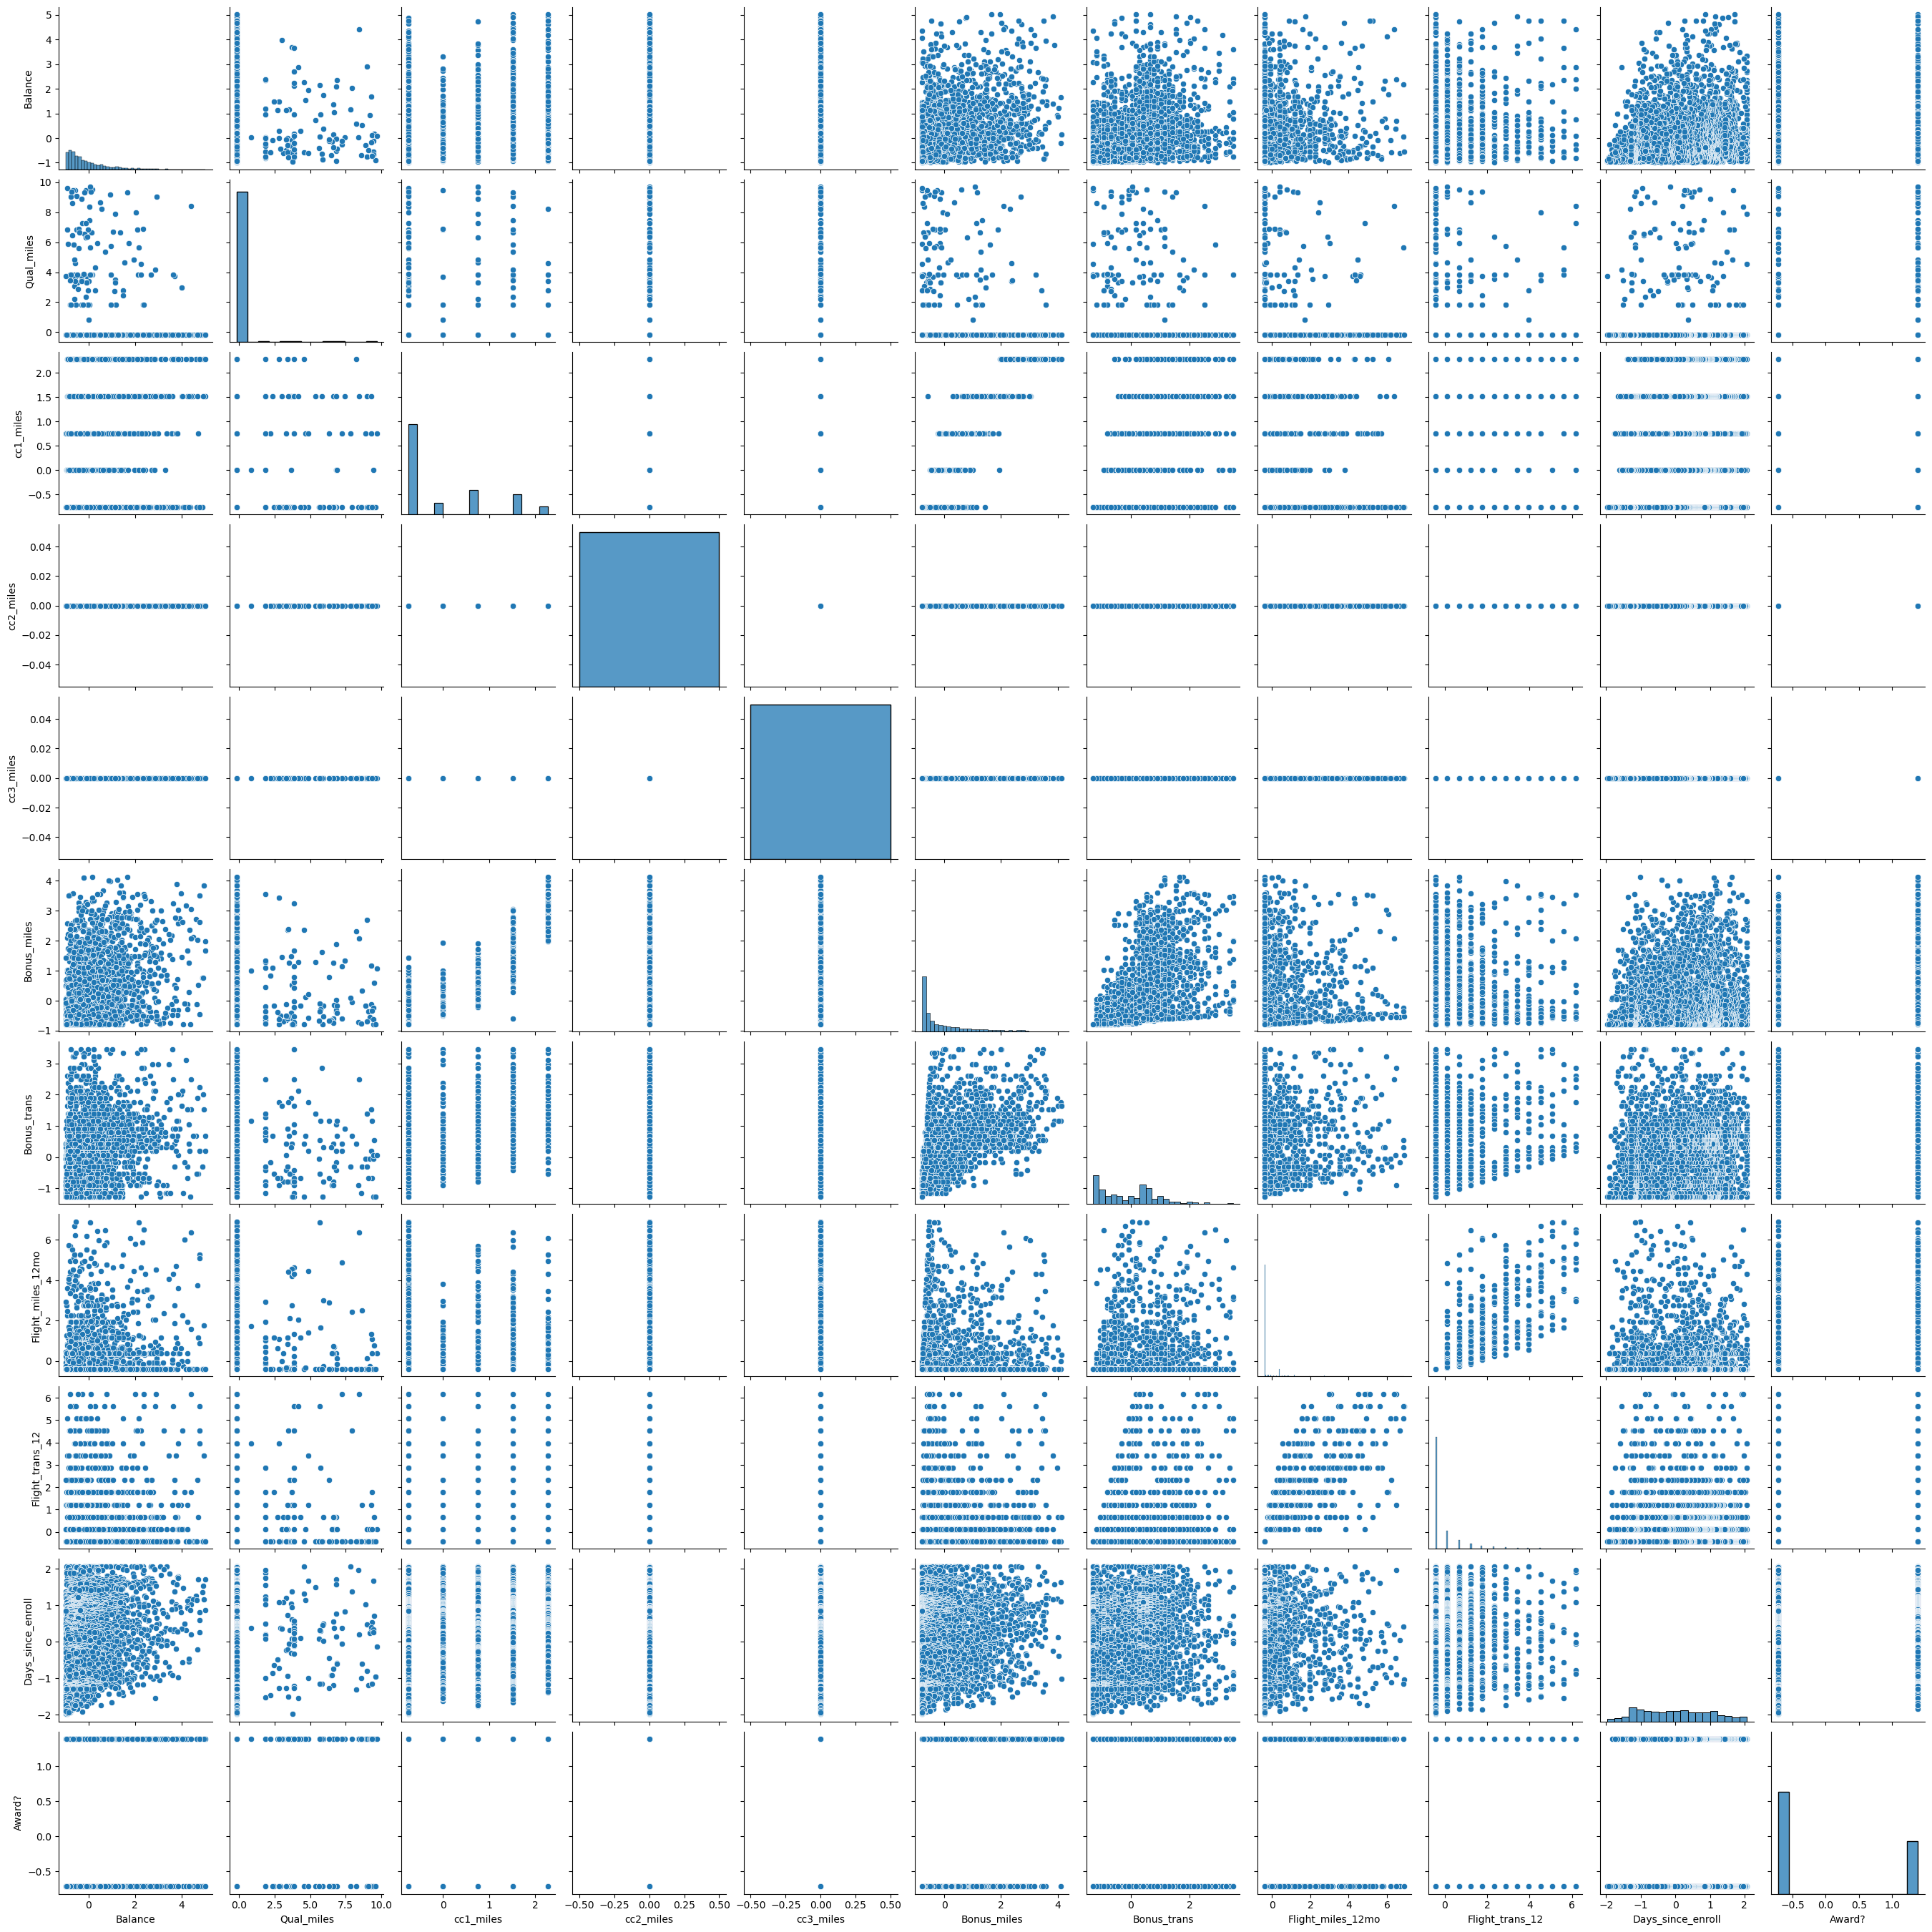

In [8]:
import seaborn as sns
import matplotlib.pyplot as plt

# Pairplot to see relationships between variables
sns.pairplot(scaled_data_df)
plt.show()


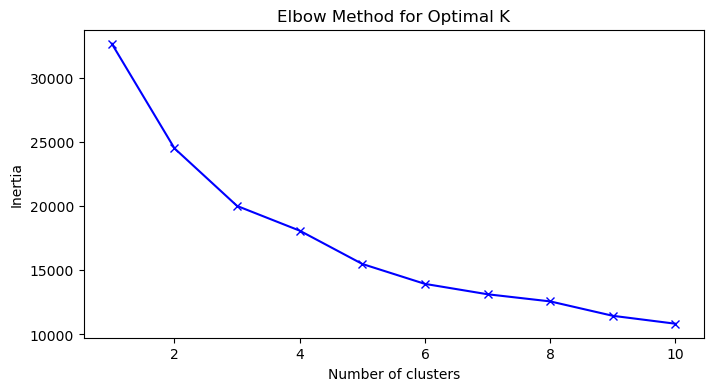

Silhouette Score for K-Means: 0.3191304239968378


In [9]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# Determine the optimal number of clusters using the elbow method
inertia = []
K = range(1, 11)
for k in K:
    kmeans = KMeans(n_clusters=k, random_state=0)
    kmeans.fit(scaled_data_df)
    inertia.append(kmeans.inertia_)

# Plot the elbow curve
plt.figure(figsize=(8, 4))
plt.plot(K, inertia, 'bx-')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.title('Elbow Method for Optimal K')
plt.show()

# Fit KMeans with the optimal number of clusters (let's assume it's 3 for now)
optimal_k = 3  # You may change this based on the elbow plot
kmeans = KMeans(n_clusters=optimal_k, random_state=0)
kmeans_labels = kmeans.fit_predict(scaled_data_df)

# Silhouette score
kmeans_silhouette = silhouette_score(scaled_data_df, kmeans_labels)
print(f'Silhouette Score for K-Means: {kmeans_silhouette}')


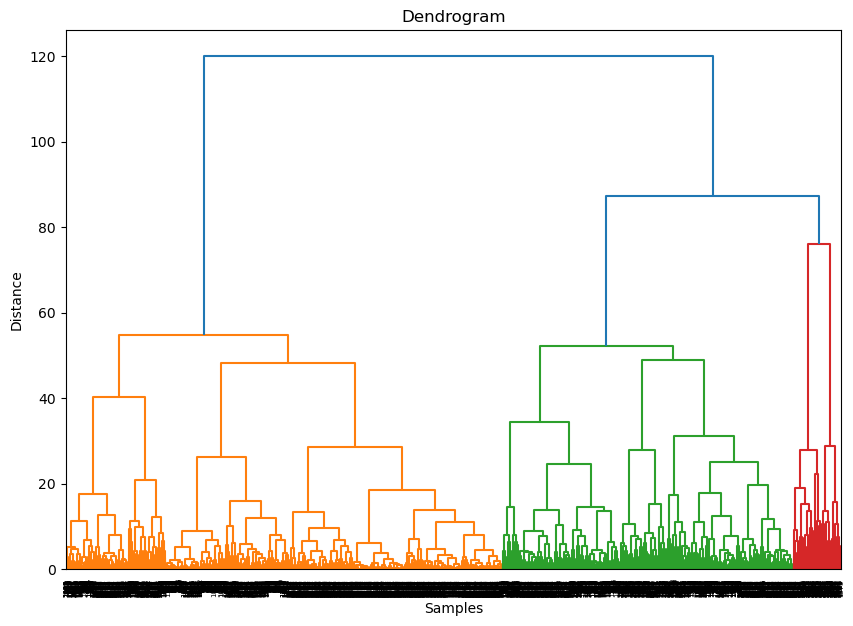

Silhouette Score for Hierarchical Clustering: 0.28440398074016243


In [10]:
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster

# Perform hierarchical clustering
Z = linkage(scaled_data_df, method='ward')

# Plot the dendrogram
plt.figure(figsize=(10, 7))
dendrogram(Z)
plt.title('Dendrogram')
plt.xlabel('Samples')
plt.ylabel('Distance')
plt.show()

# Fit Hierarchical clustering with the optimal number of clusters (let's assume it's 3 for now)
hierarchical_labels = fcluster(Z, t=optimal_k, criterion='maxclust')

# Silhouette score
hierarchical_silhouette = silhouette_score(scaled_data_df, hierarchical_labels)
print(f'Silhouette Score for Hierarchical Clustering: {hierarchical_silhouette}')


In [11]:
from sklearn.cluster import DBSCAN

# Fit DBSCAN with epsilon and min_samples (let's assume eps=0.5 and min_samples=5 for now)
dbscan = DBSCAN(eps=0.5, min_samples=5)
dbscan_labels = dbscan.fit_predict(scaled_data_df)

# Filter out noise points
filtered_dbscan_labels = dbscan_labels[dbscan_labels != -1]
filtered_scaled_data_df = scaled_data_df[dbscan_labels != -1]

# Silhouette score
if len(set(filtered_dbscan_labels)) > 1:  # Ensure there's more than one cluster
    dbscan_silhouette = silhouette_score(filtered_scaled_data_df, filtered_dbscan_labels)
else:
    dbscan_silhouette = -1  # Invalid silhouette score for single/no cluster

print(f'Silhouette Score for DBSCAN: {dbscan_silhouette}')


Silhouette Score for DBSCAN: -0.1317076393098861


In [12]:
# Analyze and interpret clusters
# Add the cluster labels to the DataFrame for easier analysis
scaled_data_df['KMeans_Labels'] = kmeans_labels
scaled_data_df['Hierarchical_Labels'] = hierarchical_labels
scaled_data_df['DBSCAN_Labels'] = dbscan_labels

# Display the first few rows with the cluster labels
scaled_data_df.head()

# Analyze the characteristics of each cluster
kmeans_clusters = scaled_data_df.groupby('KMeans_Labels').mean()
hierarchical_clusters = scaled_data_df.groupby('Hierarchical_Labels').mean()
dbscan_clusters = scaled_data_df[dbscan_labels != -1].groupby('DBSCAN_Labels').mean()

# Display the characteristics
print('K-Means Clusters:')
print(kmeans_clusters)
print('Hierarchical Clusters:')
print(hierarchical_clusters)
print('DBSCAN Clusters:')
print(dbscan_clusters)


K-Means Clusters:
                Balance  Qual_miles  cc1_miles  cc2_miles  cc3_miles  \
KMeans_Labels                                                          
0              0.571355    0.486828  -0.003926        0.0        0.0   
1             -0.369471   -0.036362  -0.647513        0.0        0.0   
2              0.551373   -0.036238   1.177582        0.0        0.0   

               Bonus_miles  Bonus_trans  Flight_miles_12mo  Flight_trans_12  \
KMeans_Labels                                                                 
0                 0.250546     0.653673           3.015296         2.974829   
1                -0.590547    -0.535981          -0.253279        -0.246777   
2                 1.020571     0.836678          -0.173443        -0.176755   

               Days_since_enroll    Award?  Hierarchical_Labels  DBSCAN_Labels  
KMeans_Labels                                                                   
0                       0.117756  0.613639             2.281746

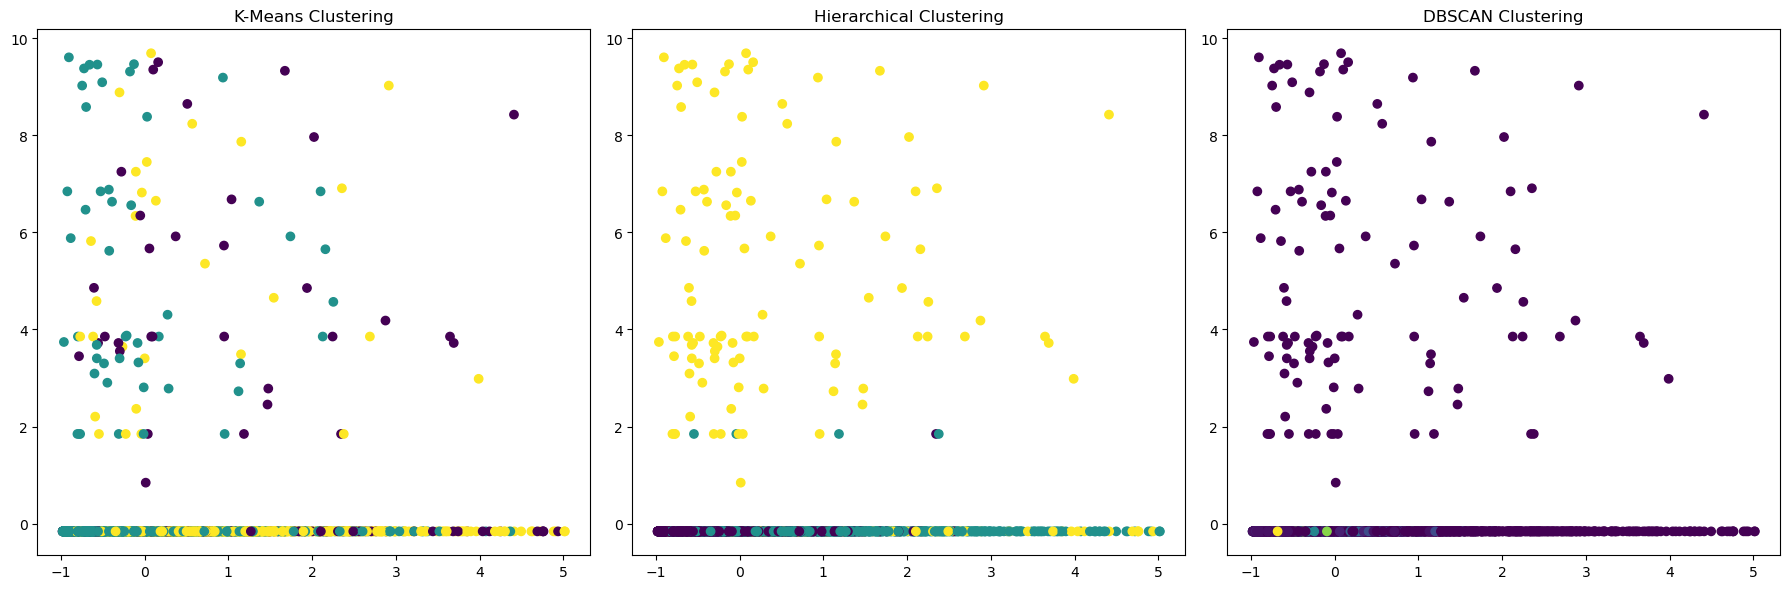

In [13]:
# Visualization using scatter plots
plt.figure(figsize=(18, 6))

# K-Means Clustering
plt.subplot(1, 3, 1)
plt.scatter(scaled_data_df.iloc[:, 0], scaled_data_df.iloc[:, 1], c=kmeans_labels, cmap='viridis')
plt.title('K-Means Clustering')

# Hierarchical Clustering
plt.subplot(1, 3, 2)
plt.scatter(scaled_data_df.iloc[:, 0], scaled_data_df.iloc[:, 1], c=hierarchical_labels, cmap='viridis')
plt.title('Hierarchical Clustering')

# DBSCAN Clustering
plt.subplot(1, 3, 3)
plt.scatter(scaled_data_df.iloc[:, 0], scaled_data_df.iloc[:, 1], c=dbscan_labels, cmap='viridis')
plt.title('DBSCAN Clustering')

plt.tight_layout()
plt.show()


In [14]:
# Evaluate the quality of clustering using silhouette score
print(f'Silhouette Score for K-Means: {kmeans_silhouette}')
print(f'Silhouette Score for Hierarchical Clustering: {hierarchical_silhouette}')
print(f'Silhouette Score for DBSCAN: {dbscan_silhouette}')


Silhouette Score for K-Means: 0.3191304239968378
Silhouette Score for Hierarchical Clustering: 0.28440398074016243
Silhouette Score for DBSCAN: -0.1317076393098861


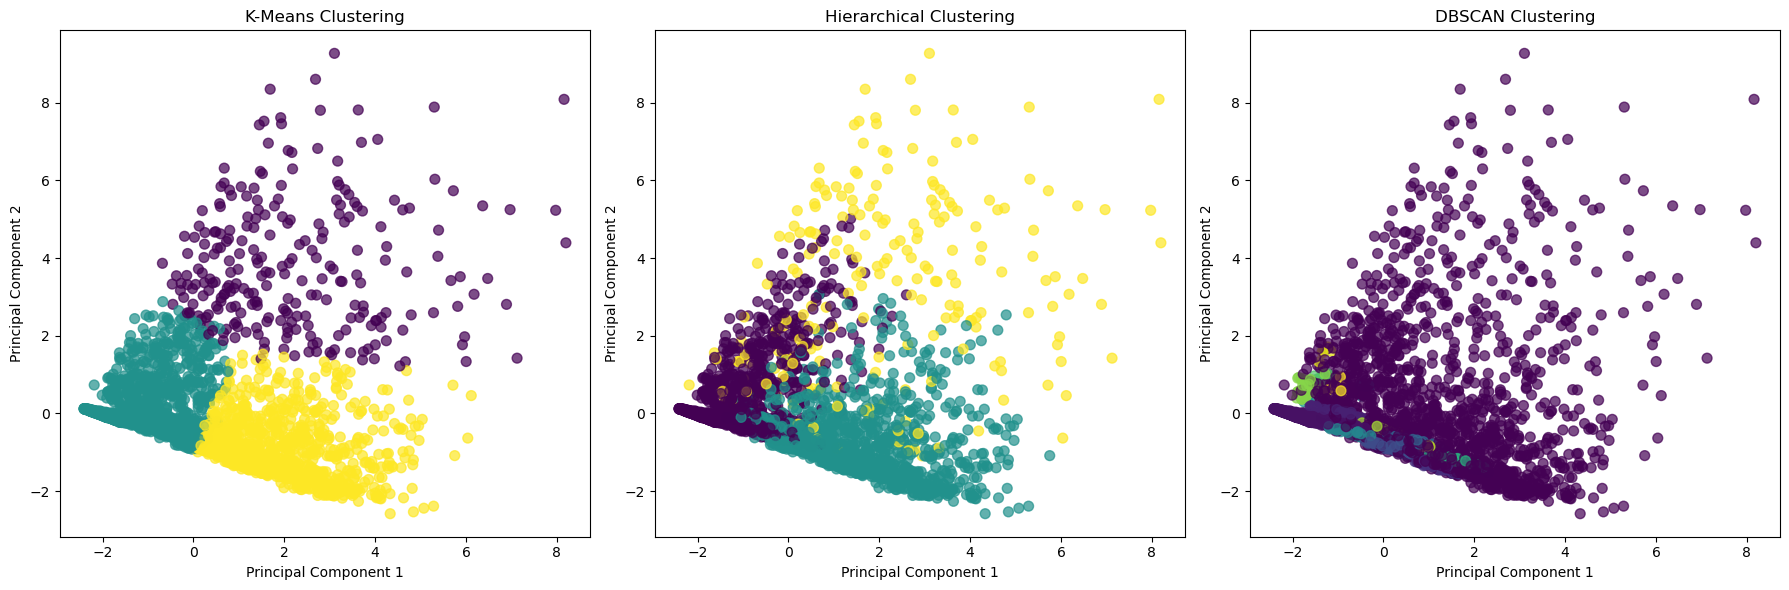

In [15]:
from sklearn.decomposition import PCA

# Reduce dimensions for visualization
pca = PCA(n_components=2)
pca_components = pca.fit_transform(scaled_data_df.drop(columns=['KMeans_Labels', 'Hierarchical_Labels', 'DBSCAN_Labels']))

# Create a DataFrame for visualization
pca_df = pd.DataFrame(data=pca_components, columns=['PC1', 'PC2'])
pca_df['KMeans_Labels'] = kmeans_labels
pca_df['Hierarchical_Labels'] = hierarchical_labels
pca_df['DBSCAN_Labels'] = dbscan_labels

# Plotting the clusters
plt.figure(figsize=(18, 6))

# K-Means Clustering
plt.subplot(1, 3, 1)
plt.scatter(pca_df['PC1'], pca_df['PC2'], c=pca_df['KMeans_Labels'], cmap='viridis', s=50, alpha=0.7)
plt.title('K-Means Clustering')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')

# Hierarchical Clustering
plt.subplot(1, 3, 2)
plt.scatter(pca_df['PC1'], pca_df['PC2'], c=pca_df['Hierarchical_Labels'], cmap='viridis', s=50, alpha=0.7)
plt.title('Hierarchical Clustering')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')

# DBSCAN Clustering
plt.subplot(1, 3, 3)
plt.scatter(pca_df['PC1'], pca_df['PC2'], c=pca_df['DBSCAN_Labels'], cmap='viridis', s=50, alpha=0.7)
plt.title('DBSCAN Clustering')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')

plt.tight_layout()
plt.show()


In [16]:
# Tune DBSCAN parameters
from sklearn.metrics import silhouette_score

best_eps = 0
best_min_samples = 0
best_silhouette = -1
eps_values = [0.3, 0.4, 0.5, 0.6, 0.7]
min_samples_values = [3, 5, 7, 10]

for eps in eps_values:
    for min_samples in min_samples_values:
        dbscan = DBSCAN(eps=eps, min_samples=min_samples)
        dbscan_labels = dbscan.fit_predict(scaled_data_df)
        
        # Filter out noise points
        filtered_dbscan_labels = dbscan_labels[dbscan_labels != -1]
        filtered_scaled_data_df = scaled_data_df[dbscan_labels != -1]
        
        # Calculate silhouette score
        if len(set(filtered_dbscan_labels)) > 1:  # Ensure there's more than one cluster
            silhouette = silhouette_score(filtered_scaled_data_df, filtered_dbscan_labels)
            if silhouette > best_silhouette:
                best_silhouette = silhouette
                best_eps = eps
                best_min_samples = min_samples

print(f'Best DBSCAN parameters: eps={best_eps}, min_samples={best_min_samples}, silhouette score={best_silhouette}')

# Run DBSCAN with best parameters
dbscan = DBSCAN(eps=best_eps, min_samples=best_min_samples)
dbscan_labels = dbscan.fit_predict(scaled_data_df)

# Update silhouette score
filtered_dbscan_labels = dbscan_labels[dbscan_labels != -1]
filtered_scaled_data_df = scaled_data_df[dbscan_labels != -1]
if len(set(filtered_dbscan_labels)) > 1:
    dbscan_silhouette = silhouette_score(filtered_scaled_data_df, filtered_dbscan_labels)
else:
    dbscan_silhouette = -1

print(f'Updated Silhouette Score for DBSCAN: {dbscan_silhouette}')


Best DBSCAN parameters: eps=0.7, min_samples=10, silhouette score=0.465153999422515
Updated Silhouette Score for DBSCAN: 0.465153999422515


In [17]:
# Evaluate the quality of clustering using silhouette score
print(f'Silhouette Score for K-Means: {kmeans_silhouette}')
print(f'Silhouette Score for Hierarchical Clustering: {hierarchical_silhouette}')
print(f'Updated Silhouette Score for DBSCAN: {dbscan_silhouette}')


Silhouette Score for K-Means: 0.3191304239968378
Silhouette Score for Hierarchical Clustering: 0.28440398074016243
Updated Silhouette Score for DBSCAN: 0.465153999422515


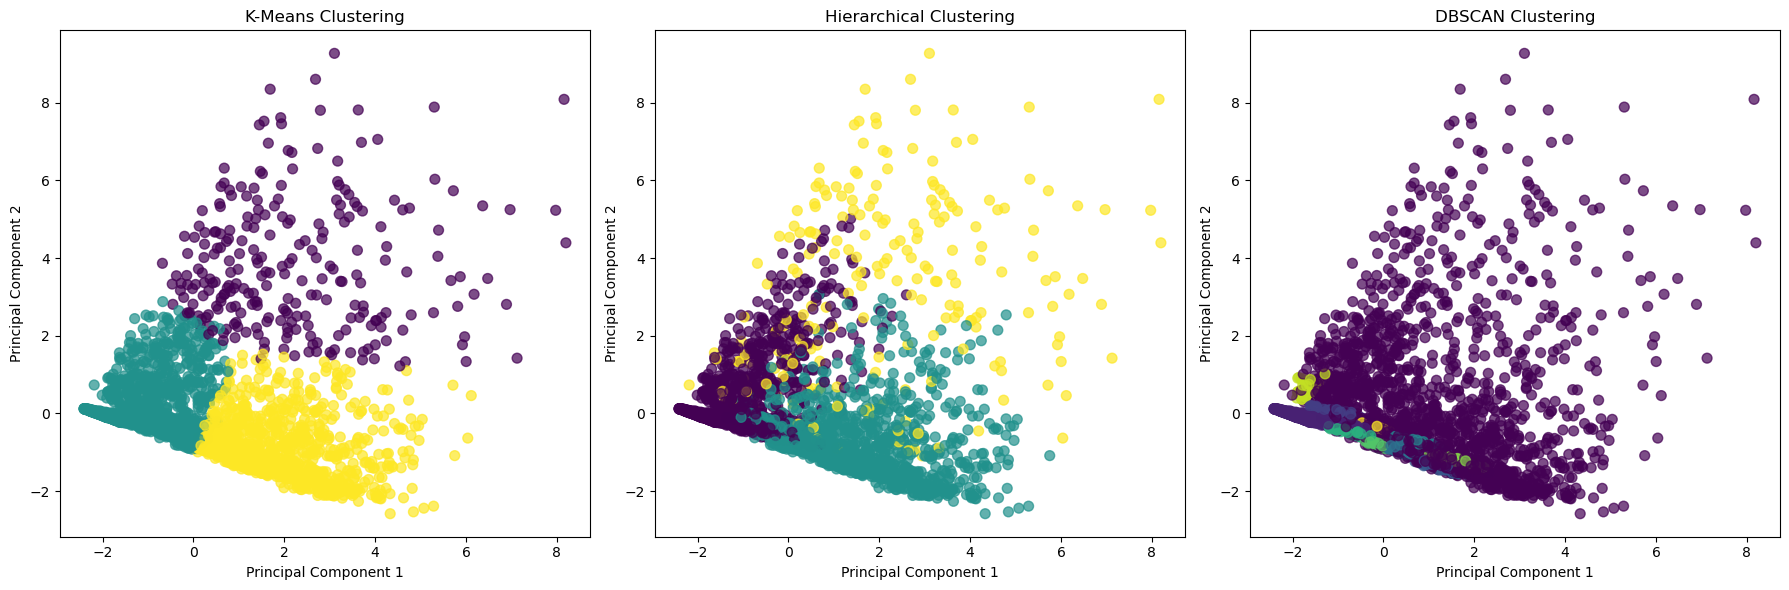

In [18]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# Reduce dimensions for visualization using PCA
pca = PCA(n_components=2)
pca_components = pca.fit_transform(scaled_data_df.drop(columns=['KMeans_Labels', 'Hierarchical_Labels', 'DBSCAN_Labels']))

# Create a DataFrame for visualization
pca_df = pd.DataFrame(data=pca_components, columns=['PC1', 'PC2'])
pca_df['KMeans_Labels'] = kmeans_labels
pca_df['Hierarchical_Labels'] = hierarchical_labels
pca_df['DBSCAN_Labels'] = dbscan_labels

# Plotting the clusters
plt.figure(figsize=(18, 6))

# K-Means Clustering
plt.subplot(1, 3, 1)
plt.scatter(pca_df['PC1'], pca_df['PC2'], c=pca_df['KMeans_Labels'], cmap='viridis', s=50, alpha=0.7)
plt.title('K-Means Clustering')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')

# Hierarchical Clustering
plt.subplot(1, 3, 2)
plt.scatter(pca_df['PC1'], pca_df['PC2'], c=pca_df['Hierarchical_Labels'], cmap='viridis', s=50, alpha=0.7)
plt.title('Hierarchical Clustering')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')

# DBSCAN Clustering
plt.subplot(1, 3, 3)
plt.scatter(pca_df['PC1'], pca_df['PC2'], c=pca_df['DBSCAN_Labels'], cmap='viridis', s=50, alpha=0.7)
plt.title('DBSCAN Clustering')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')

plt.tight_layout()
plt.show()


In [19]:
# Analyze and interpret clusters
# Add the cluster labels to the DataFrame for easier analysis
scaled_data_df['KMeans_Labels'] = kmeans_labels
scaled_data_df['Hierarchical_Labels'] = hierarchical_labels
scaled_data_df['DBSCAN_Labels'] = dbscan_labels

# Analyze the characteristics of each cluster
kmeans_clusters = scaled_data_df.groupby('KMeans_Labels').mean()
hierarchical_clusters = scaled_data_df.groupby('Hierarchical_Labels').mean()
dbscan_clusters = scaled_data_df[dbscan_labels != -1].groupby('DBSCAN_Labels').mean()

# Display the characteristics
print('K-Means Clusters:')
print(kmeans_clusters)
print('\nHierarchical Clusters:')
print(hierarchical_clusters)
print('\nDBSCAN Clusters:')
print(dbscan_clusters)


K-Means Clusters:
                Balance  Qual_miles  cc1_miles  cc2_miles  cc3_miles  \
KMeans_Labels                                                          
0              0.571355    0.486828  -0.003926        0.0        0.0   
1             -0.369471   -0.036362  -0.647513        0.0        0.0   
2              0.551373   -0.036238   1.177582        0.0        0.0   

               Bonus_miles  Bonus_trans  Flight_miles_12mo  Flight_trans_12  \
KMeans_Labels                                                                 
0                 0.250546     0.653673           3.015296         2.974829   
1                -0.590547    -0.535981          -0.253279        -0.246777   
2                 1.020571     0.836678          -0.173443        -0.176755   

               Days_since_enroll    Award?  Hierarchical_Labels  DBSCAN_Labels  
KMeans_Labels                                                                   
0                       0.117756  0.613639             2.281746

In [20]:
# Evaluate the quality of clustering using silhouette score
print(f'Silhouette Score for K-Means: {kmeans_silhouette}')
print(f'Silhouette Score for Hierarchical Clustering: {hierarchical_silhouette}')
print(f'Updated Silhouette Score for DBSCAN: {dbscan_silhouette}')


Silhouette Score for K-Means: 0.3191304239968378
Silhouette Score for Hierarchical Clustering: 0.28440398074016243
Updated Silhouette Score for DBSCAN: 0.465153999422515


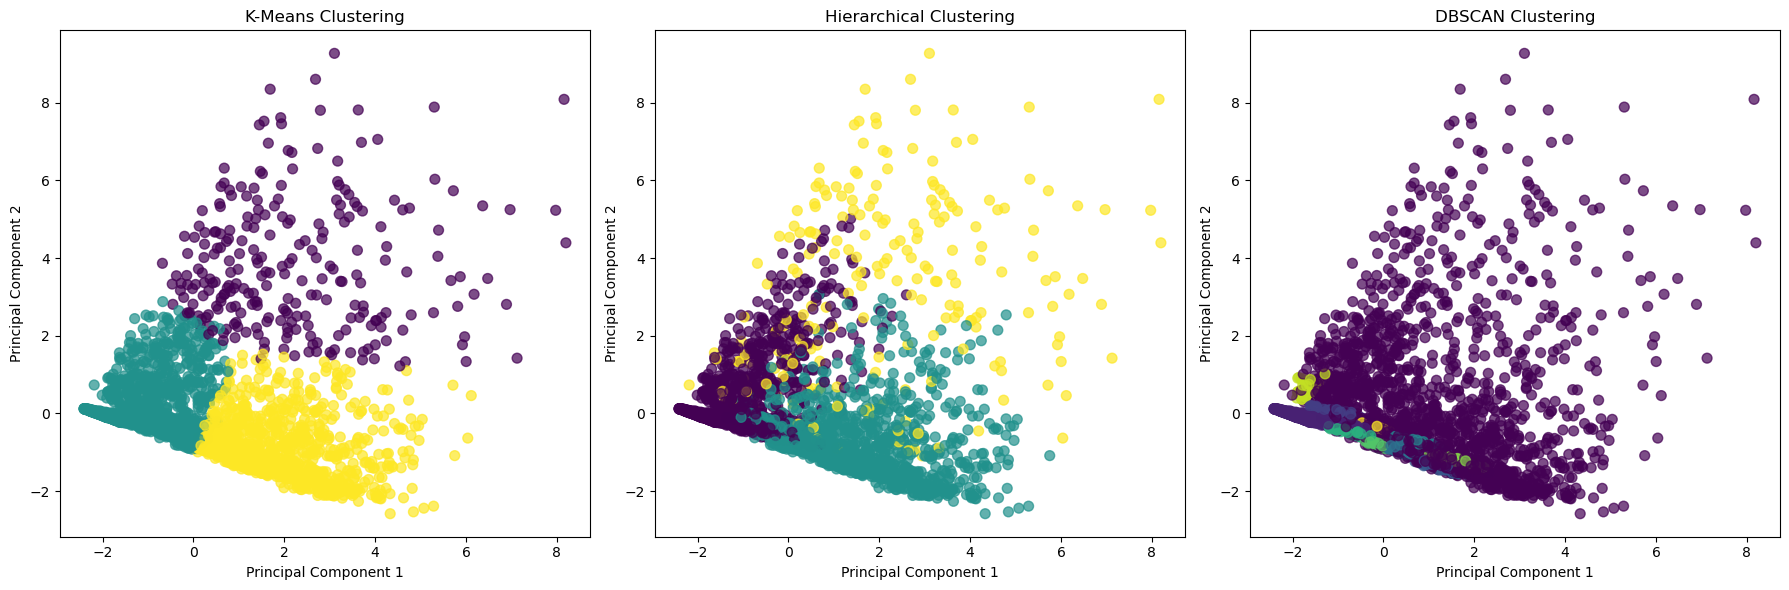

In [21]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# Reduce dimensions for visualization using PCA
pca = PCA(n_components=2)
pca_components = pca.fit_transform(scaled_data_df.drop(columns=['KMeans_Labels', 'Hierarchical_Labels', 'DBSCAN_Labels']))

# Create a DataFrame for visualization
pca_df = pd.DataFrame(data=pca_components, columns=['PC1', 'PC2'])
pca_df['KMeans_Labels'] = kmeans_labels
pca_df['Hierarchical_Labels'] = hierarchical_labels
pca_df['DBSCAN_Labels'] = dbscan_labels

# Plotting the clusters
plt.figure(figsize=(18, 6))

# K-Means Clustering
plt.subplot(1, 3, 1)
plt.scatter(pca_df['PC1'], pca_df['PC2'], c=pca_df['KMeans_Labels'], cmap='viridis', s=50, alpha=0.7)
plt.title('K-Means Clustering')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')

# Hierarchical Clustering
plt.subplot(1, 3, 2)
plt.scatter(pca_df['PC1'], pca_df['PC2'], c=pca_df['Hierarchical_Labels'], cmap='viridis', s=50, alpha=0.7)
plt.title('Hierarchical Clustering')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')

# DBSCAN Clustering
plt.subplot(1, 3, 3)
plt.scatter(pca_df['PC1'], pca_df['PC2'], c=pca_df['DBSCAN_Labels'], cmap='viridis', s=50, alpha=0.7)
plt.title('DBSCAN Clustering')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')

plt.tight_layout()
plt.show()


In [22]:
# Analyze and interpret clusters
# Add the cluster labels to the DataFrame for easier analysis
scaled_data_df['KMeans_Labels'] = kmeans_labels
scaled_data_df['Hierarchical_Labels'] = hierarchical_labels
scaled_data_df['DBSCAN_Labels'] = dbscan_labels

# Analyze the characteristics of each cluster
kmeans_clusters = scaled_data_df.groupby('KMeans_Labels').mean()
hierarchical_clusters = scaled_data_df.groupby('Hierarchical_Labels').mean()
dbscan_clusters = scaled_data_df[dbscan_labels != -1].groupby('DBSCAN_Labels').mean()

# Display the characteristics
print('K-Means Clusters:')
print(kmeans_clusters)
print('\nHierarchical Clusters:')
print(hierarchical_clusters)
print('\nDBSCAN Clusters:')
print(dbscan_clusters)


K-Means Clusters:
                Balance  Qual_miles  cc1_miles  cc2_miles  cc3_miles  \
KMeans_Labels                                                          
0              0.571355    0.486828  -0.003926        0.0        0.0   
1             -0.369471   -0.036362  -0.647513        0.0        0.0   
2              0.551373   -0.036238   1.177582        0.0        0.0   

               Bonus_miles  Bonus_trans  Flight_miles_12mo  Flight_trans_12  \
KMeans_Labels                                                                 
0                 0.250546     0.653673           3.015296         2.974829   
1                -0.590547    -0.535981          -0.253279        -0.246777   
2                 1.020571     0.836678          -0.173443        -0.176755   

               Days_since_enroll    Award?  Hierarchical_Labels  DBSCAN_Labels  
KMeans_Labels                                                                   
0                       0.117756  0.613639             2.281746

In [23]:
# Evaluate the quality of clustering using silhouette score
print(f'Silhouette Score for K-Means: {kmeans_silhouette}')
print(f'Silhouette Score for Hierarchical Clustering: {hierarchical_silhouette}')
print(f'Updated Silhouette Score for DBSCAN: {dbscan_silhouette}')


Silhouette Score for K-Means: 0.3191304239968378
Silhouette Score for Hierarchical Clustering: 0.28440398074016243
Updated Silhouette Score for DBSCAN: 0.465153999422515
